# Variant C/D Task Navigations and Clicks – Regression models

The approach for fitting regression models to predict whether users are likely to navigate to another task, or make a task click, is the same as we've used in the previous analyses. Because the outcome is binary, either a user did something or they did not, we use a logistic regression model. We add predictors iteratively until we find the most likely model. Like before, we have predictors for which variant the user had, whether they registered on desktop or mobile, and when they registered (in time since the start of the experiment).

In [1]:
# https://stackoverflow.com/a/35018739/1091835
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
## libraries
library(tidyverse)
library(data.table)
library(ggplot2)

library(lme4)

library(caret)

library(interactions)
library(multcomp)
library(emmeans)

require(gridExtra)

## library(ROCR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: mvtnorm

Loading required package: survival


Attaching package: ‘survival’


The following object is masked from ‘package

## Configuration variables

In [3]:
## Set BLAS threads to 1 so glmer doesn't use all cores
library(RhpcBLASctl)
blas_set_num_threads(1)

## parallelization
options(mc.cores = 4)

### Helper functions

In [4]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC = function(mod, val_data, col_name, plot_title, cutoff_steps = 0.1) {
  preds = predict(mod, val_data, type = "response")
  ROCR_pred = prediction(preds, val_data[[col_name]])
  ROCR_perf = performance(ROCR_pred, "tpr", "fpr")
  plot(ROCR_perf, colorize = TRUE, print.cutoffs.at = seq(0, 1, by = cutoff_steps),
       text.adj = c(-0.2, 1.7), main = plot_title)
}

## Function to output a confusion matrix
confusion_matrix = function(model_predictions, threshold, reference, levels = c("yes", "no")) {
  pred = factor(ifelse(model_predictions >= threshold, levels[1], levels[2]), levels = levels)
  truth = factor(ifelse(reference, levels[1], levels[2]), levels = levels)
  confusionMatrix(pred, truth, mode = 'prec_recall')
}


### Data import and setup

In [5]:
navigation_click_counts = fread('datasets/variant-test-2-navigation-click-counts.tsv',
                     colClasses = c(wiki_db = 'factor', user_registration = 'character'))

In this analysis, we're only interested in users in the Homepage group, with a valid variant assigned, who visited the Homepage. Here's how many of them we have:

In [8]:
length(navigation_click_counts[hp_enabled == 1 & hp_variant %in% c('C', 'D') & visited_homepage == 1]$wiki)

[1] 32615

Note that the dataset does not include known test accounts, users who were in the control group (meaning they didn't have the Homepage enabled upon registration), or users who turned the Homepage on/off during the experiment.

In [9]:
## Configuration variables for this experiment.
start_ts = as.POSIXct('2020-10-28 18:40:02', tz = 'UTC')
end_ts = as.POSIXct('2020-11-25 18:40:02', tz = 'UTC')

## Convert user_registration into a timestamp
navigation_click_counts[, user_reg_ts := as.POSIXct(user_registration, format = '%Y%m%d%H%M%S', tz = 'UTC')]

## Calculate time since start of experiment in weeks
navigation_click_counts[, exp_days := 0]
navigation_click_counts[, exp_days := difftime(user_reg_ts, start_ts, units = "days")]
navigation_click_counts[, ln_exp_days := log(1 + as.numeric(exp_days))]
navigation_click_counts[, ln_exp_weeks := log(1 + as.numeric(exp_days)/7)]

## Convert all NAs to 0, from
## https://stackoverflow.com/questions/7235657/fastest-way-to-replace-nas-in-a-large-data-table
na_to_zero = function(DT) {
  # or by number (slightly faster than by name) :
  for (j in seq_len(ncol(DT)))
    set(DT,which(is.na(DT[[j]])),j,0)
}

na_to_zero(navigation_click_counts)

## Create boolean column for whether the user navigated, or clicked
navigation_click_counts[, did_navigate := num_task_navigations > 0]
navigation_click_counts[, did_click := num_task_clicks > 0]

## set the random seed so train/test/validation splits can be reproduced
set.seed(42)

## Remove all control group users, users with an incorrect variant assignment,
## and users that didn't visit the Homepage.
exp_users = navigation_click_counts[hp_enabled == 1 & hp_variant %in% c('C', 'D') & visited_homepage == 1]

## Split the experiment users into training, testing, and validation datasets
trainIndex <- createDataPartition(exp_users$hp_variant,
                                  p = .8, 
                                  list = FALSE, 
                                  times = 1)
exp_users_train = exp_users[trainIndex,]
exp_users_second = exp_users[-trainIndex,]

testIndex = createDataPartition(exp_users_second$hp_variant, p = .5, list = FALSE, times = 1)

exp_users_test = exp_users_second[testIndex,]
exp_users_validate = exp_users_second[-testIndex,]


# Task navigations

We'll start by first modelling if the user navigated to another task or not. Then, we'll repeat the procedure for whether the user clicked on a task or not.

## Variant C/D as a predictor

In this first model, we predict whether the user edited based on the variant the user was in, while allowing the overall probability of editing to vary by wiki.

In [10]:
## 1: only variant as a predictor:
nav.model.1 = glmer(formula = did_navigate ~ hp_variant + (1 | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)

In [11]:
summary(nav.model.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_navigate ~ hp_variant + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 24647.7  24672.2 -12320.8  24641.7    26089 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6360 -0.4972 -0.4424 -0.3952  2.6910 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.05811  0.2411  
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.33192    0.06710 -19.850  < 2e-16 ***
hp_variantD -0.22582    0.03224  -7.005 2.47e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
hp_variantD -0.222

This model suggests that overall, variant D is associated with a lower probability of a user clicking to navigate to another task.

Let us see if there's variation by wiki on this.

In [12]:
## 1: variant as a group-level predictor
nav.model.1.2 = glmer(formula = did_navigate ~ hp_variant + (1 + hp_variant | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)

In [13]:
summary(nav.model.1.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_navigate ~ hp_variant + (1 + hp_variant | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 24642.9  24683.8 -12316.5  24632.9    26087 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6406 -0.4884 -0.4258 -0.3992  2.5788 

Random effects:
 Groups  Name        Variance Std.Dev. Corr 
 wiki_db (Intercept) 0.08050  0.2837        
         hp_variantD 0.01681  0.1296   -0.76
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.32114    0.07795 -16.949  < 2e-16 ***
hp_variantD -0.24465    0.05116  -4.783 1.73e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
hp_variantD -0.640

In [14]:
ranef(nav.model.1.2)

$wiki_db
        (Intercept) hp_variantD
arwiki -0.515548158  0.18665967
cswiki  0.310026039 -0.13353815
fawiki -0.413357380  0.22011876
frwiki -0.115555679 -0.04256411
hewiki  0.008747447 -0.02444740
huwiki -0.094877413  0.04086996
hywiki  0.072321848  0.01187544
kowiki -0.267034837  0.07335061
plwiki  0.178268728 -0.04561649
ptwiki -0.201062600  0.05918507
ruwiki  0.242230288 -0.05334706
srwiki  0.137621354 -0.08203056
svwiki -0.058987132 -0.03318886
trwiki  0.430562537 -0.03588451
ukwiki -0.012228529 -0.01658084
viwiki  0.342760361 -0.13717501

with conditional variances for “wiki_db” 

The model is not singular, which suggests that there's enough variation and data to support it. However, the BIC is much worse than the first model. So while there *is* some variation between wikis, it's not clear that it's large enough to be meaningful.

## Desktop/mobile registration

We add whether the user registered on desktop or mobile as a predictor.

In [15]:
## 2: add desktop/mobile
nav.model.2 = glmer(formula = did_navigate ~ hp_variant + reg_on_mobile + (1 | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)


In [16]:
summary(nav.model.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_navigate ~ hp_variant + reg_on_mobile + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 24451.8  24484.5 -12221.9  24443.8    26088 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6884 -0.5095 -0.4319 -0.3586  2.9772 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.04385  0.2094  
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.16858    0.06087 -19.197  < 2e-16 ***
hp_variantD   -0.22246    0.03235  -6.876 6.15e-12 ***
reg_on_mobile -0.49182    0.03548 -13.862  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) hp_vrD
hp_variantD -0.245       
reg_on_mobl -0.177 -0.003

In [93]:
## 2: desktop/mobile with group-level variation
nav.model.2.1 = glmer(formula = did_navigate ~ hp_variant + reg_on_mobile + (1 + reg_on_mobile | wiki_db),
                      family = binomial(link = "logit"), data = exp_users_train)

In [94]:
summary(nav.model.2.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_navigate ~ hp_variant + reg_on_mobile + (1 + reg_on_mobile |  
    wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 24424.1  24473.1 -12206.0  24412.1    26086 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7161 -0.5059 -0.4408 -0.3352  2.9872 

Random effects:
 Groups  Name          Variance Std.Dev. Corr 
 wiki_db (Intercept)   0.05438  0.2332        
         reg_on_mobile 0.05761  0.2400   -0.50
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.17252    0.06693 -17.518  < 2e-16 ***
hp_variantD   -0.22319    0.03238  -6.893 5.47e-12 ***
reg_on_mobile -0.46869    0.07867  -5.958 2.56e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) hp_vrD
hp_vari

In [97]:
ranef(nav.model.2.1)

$wiki_db
       (Intercept) reg_on_mobile
arwiki -0.28339073  -0.040906985
cswiki  0.18349192  -0.080352011
fawiki -0.13204157  -0.078081501
frwiki -0.19043205   0.044456144
hewiki -0.01393726   0.016980118
huwiki -0.12756729   0.108101585
hywiki  0.14236969  -0.145623758
kowiki -0.31990016   0.259099557
plwiki  0.13852223  -0.121741263
ptwiki  0.02358572  -0.344953588
ruwiki  0.10203630   0.325563591
srwiki  0.06110605  -0.000561578
svwiki -0.22430722   0.336343092
trwiki  0.50463695  -0.280154273
ukwiki -0.04706044  -0.005512077
viwiki  0.22126917   0.024209141

with conditional variances for “wiki_db” 

In [95]:
coef(nav.model.2.1)

$wiki_db
       (Intercept) hp_variantD reg_on_mobile
arwiki  -1.4559097  -0.2231905    -0.5095994
cswiki  -0.9890270  -0.2231905    -0.5490444
fawiki  -1.3045605  -0.2231905    -0.5467739
frwiki  -1.3629510  -0.2231905    -0.4242362
hewiki  -1.1864562  -0.2231905    -0.4517123
huwiki  -1.3000862  -0.2231905    -0.3605908
hywiki  -1.0301493  -0.2231905    -0.6143161
kowiki  -1.4924191  -0.2231905    -0.2095928
plwiki  -1.0339967  -0.2231905    -0.5904336
ptwiki  -1.1489332  -0.2231905    -0.8136460
ruwiki  -1.0704826  -0.2231905    -0.1431288
srwiki  -1.1114129  -0.2231905    -0.4692539
svwiki  -1.3968262  -0.2231905    -0.1323493
trwiki  -0.6678820  -0.2231905    -0.7488466
ukwiki  -1.2195794  -0.2231905    -0.4742044
viwiki  -0.9512498  -0.2231905    -0.4444832

attr(,"class")
[1] "coef.mer"

We see indications that the user registering on mobile is strongly associated with lower probability of task navigation, and that there's meaningful variation between wikis when it comes to this effect.

## Interaction between variant and desktop/mobile

One of the key findings of our previous analysis was that there was a strong interaction effect between which variant group the user was in, and whether they registered on desktop or mobile. An *interaction effect* means that the effect of one of the predictors is altered by the effect of another predictor. In our case, since both predictor are binary categorical variables, it means that the outcome is altered depending on the combination of those categories.

In [17]:
## 3: desktop/mobile interaction
nav.model.3 = glmer(formula = did_navigate ~ hp_variant * reg_on_mobile + (1 | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)

In [18]:
summary(nav.model.3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_navigate ~ hp_variant * reg_on_mobile + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 24453.5  24494.3 -12221.7  24443.5    26087 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6904 -0.5109 -0.4347 -0.3610  2.9579 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.04384  0.2094  
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -1.16283    0.06177 -18.824  < 2e-16 ***
hp_variantD               -0.23487    0.03971  -5.915 3.32e-09 ***
reg_on_mobile             -0.50907    0.04783 -10.644  < 2e-16 ***
hp_variantD:reg_on_mobile  0.03694    0.06848   0.539     0.59    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
   

This is different from what we've seen in previous analyses, where there's been an interaction effect. In this case, we instead find no indication of that. This means that the negative association with Variant D is consistent between desktop & mobile, and that the negative effect of mobile is consistent between variants.

In [ ]:
plot_ROC(edit.model.3, exp_users_validate, 'did_edit', "Model 3 ROC", cutoff_steps = 0.025)

## Variation across wikis

We test if the effect of these predictors vary significantly by wiki.

In [19]:
## 4: both variant and platform as group-level predictors
nav.model.4 = glmer(formula = did_navigate ~ hp_variant + reg_on_mobile +
                      (1 + hp_variant + reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)

In [ ]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(nav.model.4, c("theta", "fixef"))
nav.model.4 = update(nav.model.4, start = start_vals,
                     control = glmerControl(optCtrl = list(maxfun = 2e4)))


In [21]:
summary(nav.model.4)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_navigate ~ hp_variant + reg_on_mobile + (1 + hp_variant +  
    reg_on_mobile | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 24421.7  24495.3 -12201.9  24403.7    26083 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7119 -0.5124 -0.4440 -0.3458  2.9170 

Random effects:
 Groups  Name          Variance Std.Dev. Corr       
 wiki_db (Intercept)   0.06088  0.2467              
         hp_variantD   0.01936  0.1391   -0.32      
         reg_on_mobile 0.06296  0.2509   -0.33 -0.55
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.16391    0.07064 -16.477  < 2e-16 ***
hp_variantD   -0.24683    0.05424  -4.550 5.35e-06 ***
reg_on_mobile -0.45285    0.08084  -5.602 2.12e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’

The model converges, and it's not singular. However, we notice that the BIC is much worse compared to the one that only has desktop/mobile as a group-level predictor. This indicates that we want to discard this more complex model in favour of having just desktop/mobile as a group-level predictor.

## Time as a predictor

Lastly, we add time as a predictor, in this case a variable measuring the number of weeks between when the user registered and the start of the experiment. This enables us to understand if the probability of a user editing changes as time progresses.

In [102]:
## 5: add time
nav.model.5 = glmer(formula = did_navigate ~ hp_variant + reg_on_mobile +
                      ln_exp_weeks + (1 + reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)


In [103]:
summary(nav.model.5)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_navigate ~ hp_variant + reg_on_mobile + ln_exp_weeks + (1 +  
    reg_on_mobile | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 24425.5  24482.6 -12205.7  24411.5    26085 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7270 -0.5099 -0.4419 -0.3398  3.0132 

Random effects:
 Groups  Name          Variance Std.Dev. Corr 
 wiki_db (Intercept)   0.05430  0.2330        
         reg_on_mobile 0.05757  0.2399   -0.50
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.14136    0.07726 -14.774  < 2e-16 ***
hp_variantD   -0.22319    0.03238  -6.893 5.48e-12 ***
reg_on_mobile -0.46918    0.07865  -5.965 2.44e-09 ***
ln_exp_weeks  -0.03002    0.03726  -0.806     0.42    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 

In [104]:
## 5.1: time in days
nav.model.5.1 = glmer(formula = did_navigate ~ hp_variant + reg_on_mobile +
                      ln_exp_days + (1 + reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)


In [105]:
summary(nav.model.5.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_navigate ~ hp_variant + reg_on_mobile + ln_exp_days + (1 +  
    reg_on_mobile | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 24425.3  24482.5 -12205.6  24411.3    26085 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7334 -0.5100 -0.4418 -0.3418  3.0121 

Random effects:
 Groups  Name          Variance Std.Dev. Corr 
 wiki_db (Intercept)   0.05430  0.233         
         reg_on_mobile 0.05759  0.240    -0.50
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.12295    0.08631 -13.011  < 2e-16 ***
hp_variantD   -0.22315    0.03238  -6.891 5.53e-12 ***
reg_on_mobile -0.46917    0.07866  -5.964 2.46e-09 ***
ln_exp_days   -0.01959    0.02157  -0.908    0.364    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘

It appears that time does not have an effect in this experiment, and adding it does not improve fitness as the BIC is lower. Since the experiment only ran over 4 weeks, and there isn't anything that significantly changes wiki processes (e.g. there's not a need for support systems to ramp up capacity), it makes sense that time isn't a strong factor here. Given the lower BIC and the lack of a significant predictor, I choose to remove it again.

I went back and looked at the Variant A/B analysis, and there we again found that time was not a significant predictor and kept it out of the models. This indicates to me that for these relatively short experiments, time is a factor if there is some specific component that it accounts for (e.g. ramping up as mentioned above). Alternatively, we might model it using some kind of autoregressive function to account for weekly variation, if that's meaningful. In short, we need specific hypotheses about time effects for them to be meaningful, and they're likely going to need more advanced methods for them to work.

## Model across the entire dataset

Our previous models were trained on a random 80% of our dataset. We switch to the full dataset and model again to get a sense of the predictors across all available data.

In [106]:
## 7: full model
nav.model.full = glmer(formula = did_navigate ~ hp_variant + reg_on_mobile + (1 + reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users)

In [107]:
summary(nav.model.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_navigate ~ hp_variant + reg_on_mobile + (1 + reg_on_mobile |  
    wiki_db)
   Data: exp_users

     AIC      BIC   logLik deviance df.resid 
 30510.9  30561.2 -15249.4  30498.9    32609 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7258 -0.5108 -0.4402 -0.3343  3.0216 

Random effects:
 Groups  Name          Variance Std.Dev. Corr 
 wiki_db (Intercept)   0.05391  0.2322        
         reg_on_mobile 0.05488  0.2343   -0.38
Number of obs: 32615, groups:  wiki_db, 16

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.18263    0.06511 -18.164  < 2e-16 ***
hp_variantD   -0.21941    0.02896  -7.577 3.53e-14 ***
reg_on_mobile -0.47528    0.07484  -6.351 2.14e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) hp_vrD
hp_variantD -

Estimating the effects using the "divide by 4 rule".

In [108]:
fixef(nav.model.full)[2] / 4

hp_variantD 
-0.05485272

In [109]:
cbind(rownames(coef(nav.model.full)$wiki_db),
      round(100 * coef(nav.model.full)$wiki_db$reg_on_mobile / 4, 3))

arwiki,-12.367
cswiki,-10.158
fawiki,-13.572
frwiki,-10.93
hewiki,-12.485
huwiki,-10.368
hywiki,-15.895
kowiki,-8.167
plwiki,-14.816
ptwiki,-21.191
ruwiki,-3.267


The model across the full dataset shows the same trends as we saw with this model on the smaller dataset. In summary:

1. We find indication of meaningful variation between wikis when it comes to the effects of individual predictors, but this variation does not change the direction of the effects. Instead it modifies the magnitude. It's unclear whether including this in the model is meaningful.
2. Users who are on mobile are less likely to navigate between tasks.
3. Users who get Variant D are less likely to navigate between tasks.

### Interaction sanity check

Let's just test for interaction because we can.

In [121]:
## 7: full model
nav.model.full.2 = glmer(formula = did_navigate ~ hp_variant * reg_on_mobile + (1 + reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users)

In [122]:
summary(nav.model.full.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_navigate ~ hp_variant * reg_on_mobile + (1 + reg_on_mobile |  
    wiki_db)
   Data: exp_users

     AIC      BIC   logLik deviance df.resid 
 30512.2  30570.9 -15249.1  30498.2    32608 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7287 -0.5103 -0.4442 -0.3374  2.9942 

Random effects:
 Groups  Name          Variance Std.Dev. Corr 
 wiki_db (Intercept)   0.05395  0.2323        
         reg_on_mobile 0.05478  0.2340   -0.38
Number of obs: 32615, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -1.17482    0.06587 -17.836  < 2e-16 ***
hp_variantD               -0.23644    0.03553  -6.655 2.84e-11 ***
reg_on_mobile             -0.49902    0.08019  -6.223 4.87e-10 ***
hp_variantD:reg_on_mobile  0.05089    0.06138   0.829    0.407    
---
Signif. codes:  0 

Nah, there's no interaction.

## Overview table

Since we've found that results vary by wiki, where the user registered, and what variant they saw, we create an overview table to show how the probability changes.

In [ ]:
visit_counts = exp_users[, list(n_visitors = sum(.N)),
                       by = c('wiki_db', 'reg_on_mobile', 'hp_variant')]
nav_counts = exp_users[did_navigate == 1, list(n_navigated = sum(.N)),
                        by = c('wiki_db', 'reg_on_mobile', 'hp_variant')]
merged_nav_counts = merge(visit_counts, nav_counts, by = c('wiki_db', 'reg_on_mobile', 'hp_variant'))
merged_nav_counts[, percent_navigated := 100 * n_navigated / n_visitors]

In [112]:
## We'll focus on Arabic, Czech, Korean, and Vietnamese, to compare the numbers with Variant A/B
merged_nav_counts[wiki_db %in% c('arwiki', 'cswiki', 'kowiki', 'viwiki')]

wiki_db,reg_on_mobile,hp_variant,n_visitors,n_navigated,percent_navigated
<fct>,<int>,<chr>,<int>,<int>,<dbl>
arwiki,0,C,720,122,16.94444
arwiki,0,D,679,109,16.05302
arwiki,1,C,1182,121,10.23689
arwiki,1,D,1186,135,11.38280
cswiki,0,C,277,85,30.68592
cswiki,0,D,302,58,19.20530
cswiki,1,C,74,18,24.32432
cswiki,1,D,79,12,15.18987
kowiki,0,C,165,28,16.96970


In [119]:
merged_nav_counts[, platform := 'desktop']
merged_nav_counts[reg_on_mobile == 1, platform := 'mobile']
merged_nav_counts$platform = factor(merged_nav_counts$platform)

merged_nav_counts$hp_variant = factor(merged_nav_counts$hp_variant)

In [45]:
plots = lapply(unique(merged_nav_counts$wiki_db), function(w) {
    ggplot(merged_nav_counts[wiki_db == w], aes(x = platform, y = percent_navigated, fill = hp_variant)) +
        theme_bw() +
        theme(axis.title.x = element_text(size = rel(1.5)),
            axis.text.x = element_text(size = rel(1.25)),
            axis.title.y = element_text(size = rel(1.5)),
            axis.text.y = element_text(size = rel(1.25))) +
        scale_fill_brewer("Variant", palette = 'Set1') +
        labs(x = "Platform", y = "Probability (in %)", title = w) +
        geom_col(position = "dodge2")
})

# ggsave(plot = g, file = "graphs/tagged_edit_probabilities.png",
#       width = 14, height = 7, units = "in", dpi = "retina")

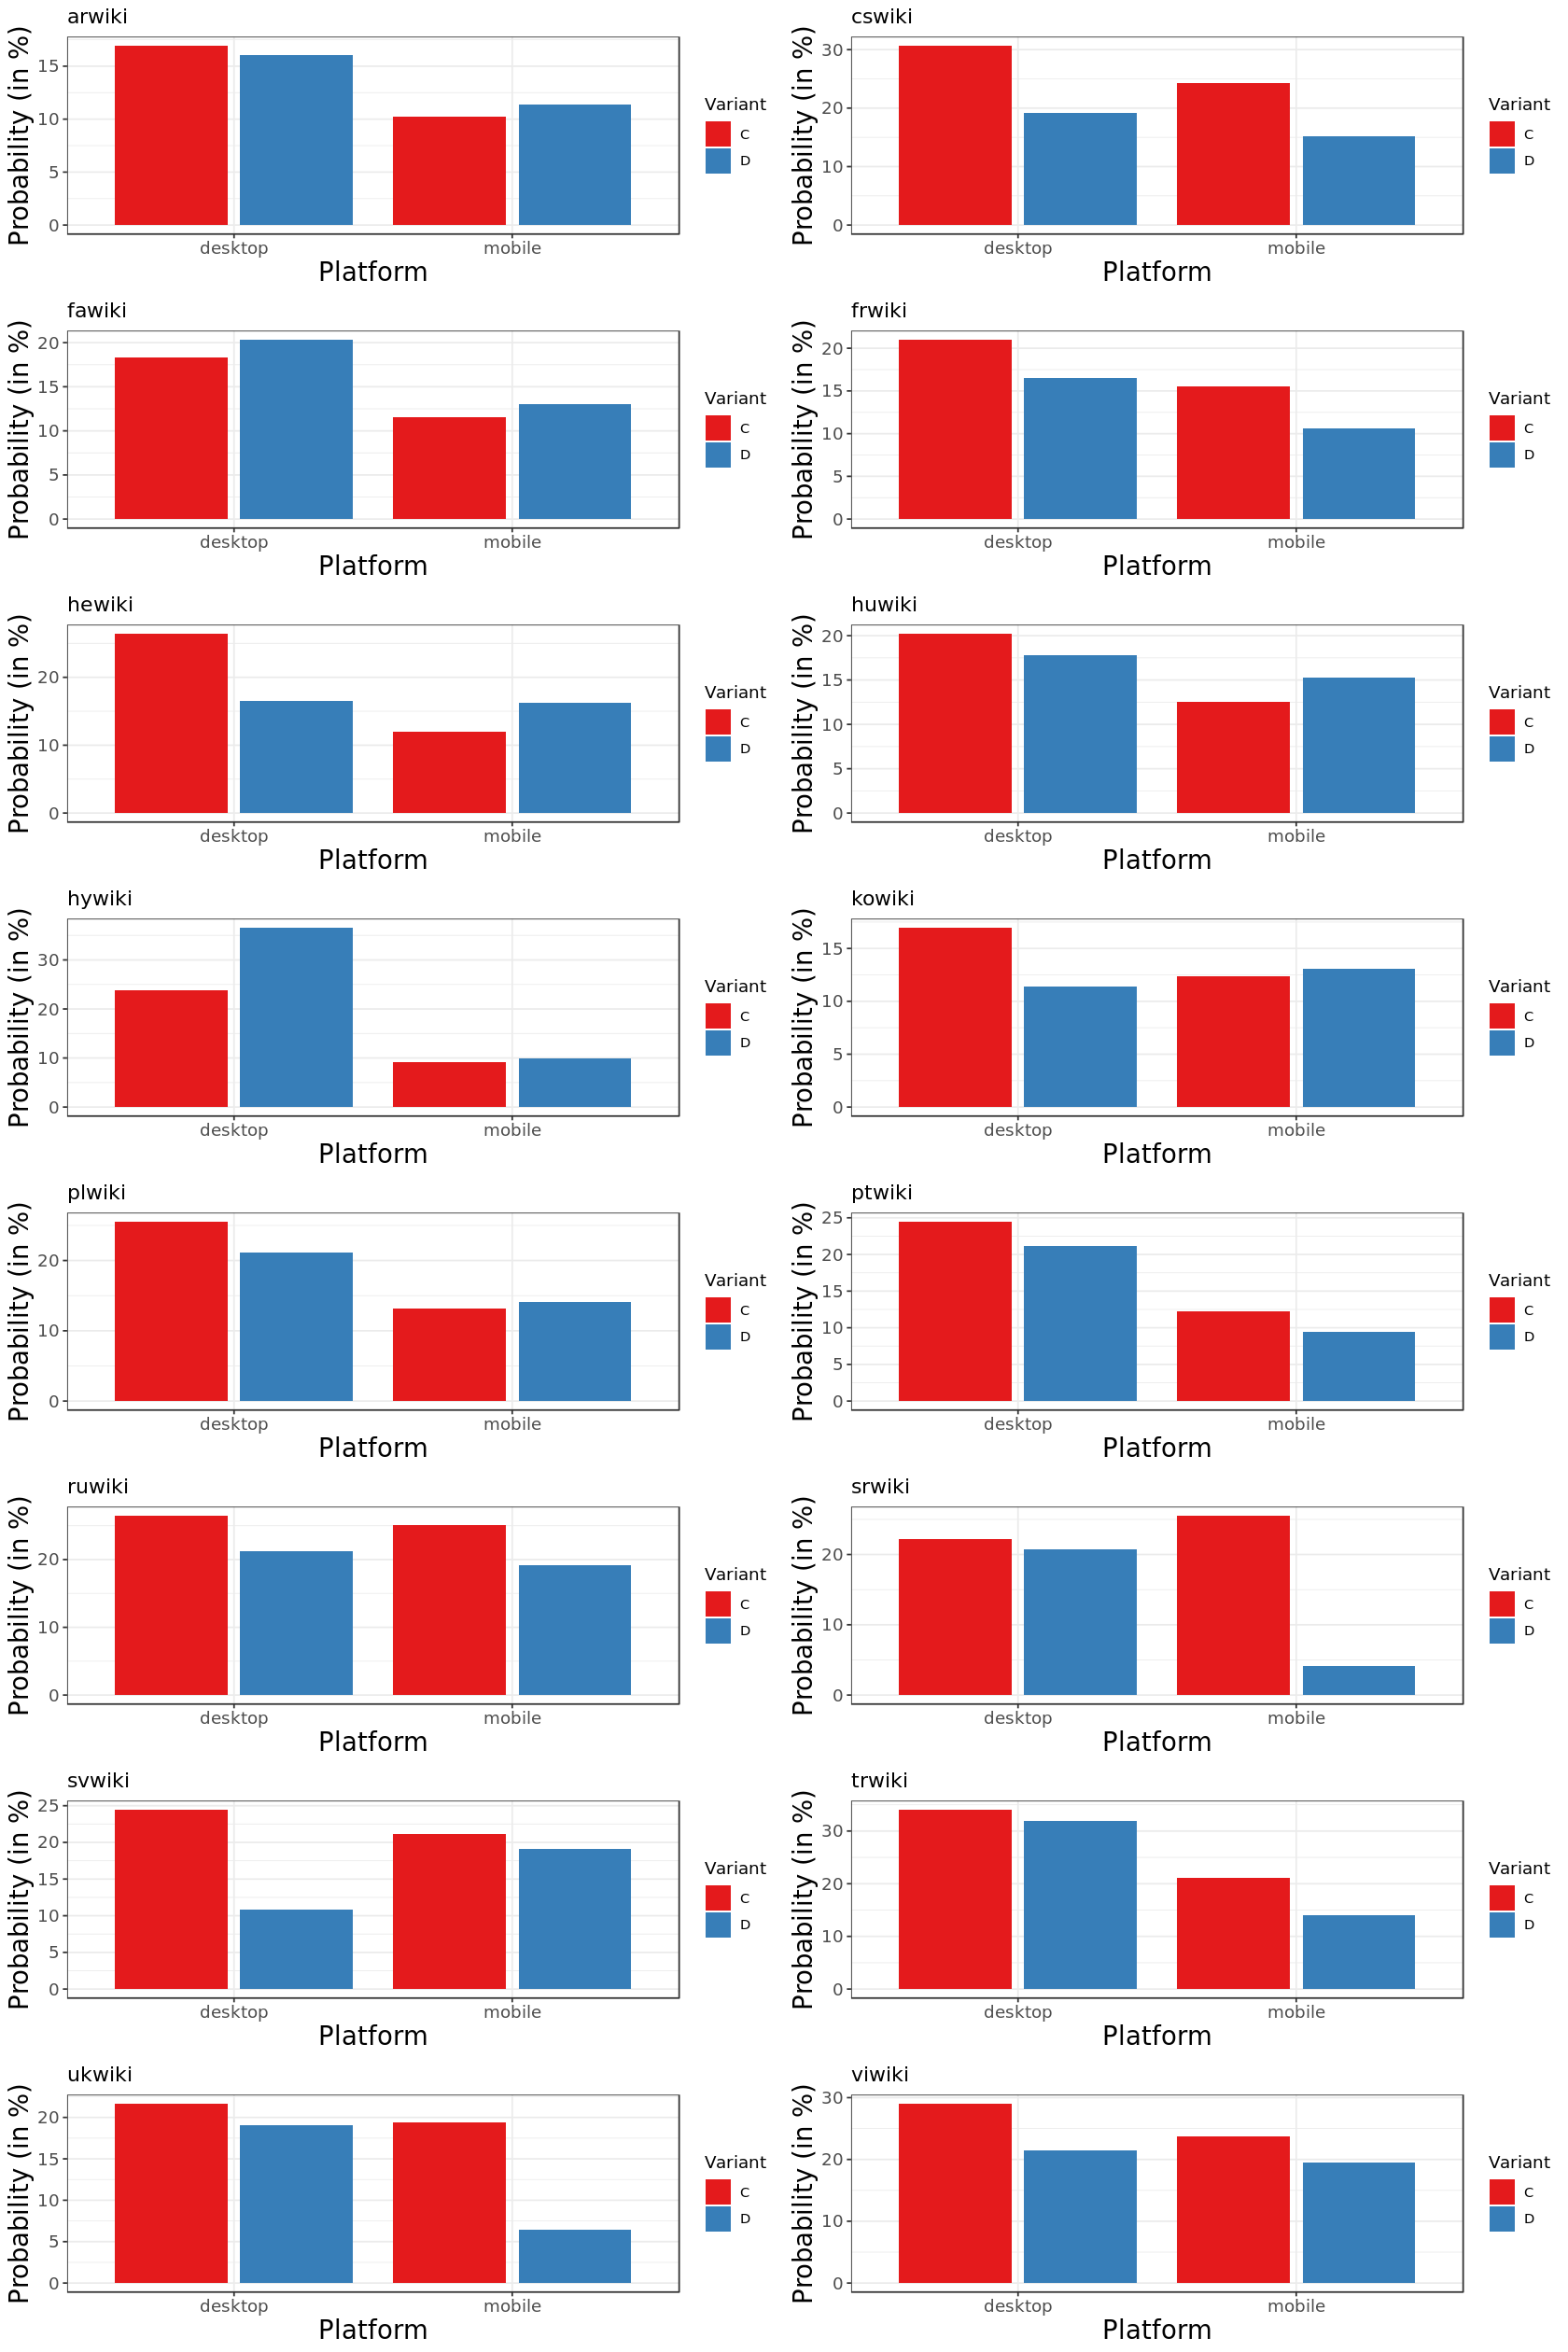

In [46]:
options(repr.plot.width = 14, repr.plot.height = 21)
grid.arrange(grobs = plots, ncol = 2)

# Task clicks

We'll next model if the user clicked on a suggested task. This is the same procedure as for task navigation, except with a different outcome.

## Variant C/D as a predictor

In this first model, we predict whether the user clicked on a task based on the variant the user was in, while allowing the overall probability of editing to vary by wiki.

In [47]:
## 1: only variant as a predictor:
click.model.1 = glmer(formula = did_click ~ hp_variant + (1 | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)

In [48]:
summary(click.model.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_click ~ hp_variant + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 19613.9  19638.4  -9804.0  19607.9    26089 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.4700 -0.4069 -0.3653 -0.3193  3.4810 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.06267  0.2503  
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.88818    0.07243 -26.070  < 2e-16 ***
hp_variantD -0.17161    0.03753  -4.573 4.82e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
hp_variantD -0.240

This model suggests that overall, variant D is associated with a lower probability of a user clicking on a suggested task.

Let us see if there's variation by wiki on this.

In [49]:
## 1: variant as a group-level predictor
click.model.1.2 = glmer(formula = did_click ~ hp_variant + (1 + hp_variant | wiki_db),
                        family = binomial(link = "logit"), data = exp_users_train)

boundary (singular) fit: see ?isSingular



In [ ]:
summary(click.model.1.2)

The model is singular, which suggests that there's not enough variation to identify it. We've come across this many times before, and as we did then we again discard this model.

## Desktop/mobile registration

We add whether the user registered on desktop or mobile as a predictor.

In [50]:
## 2: add desktop/mobile
click.model.2 = glmer(formula = did_click ~ hp_variant + reg_on_mobile + (1 | wiki_db),
                      family = binomial(link = "logit"), data = exp_users_train)


In [51]:
summary(click.model.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_click ~ hp_variant + reg_on_mobile + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 19615.9  19648.6  -9803.9  19607.9    26088 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.4705 -0.4065 -0.3645 -0.3189  3.4880 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.06275  0.2505  
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.886095   0.073890 -25.526  < 2e-16 ***
hp_variantD   -0.171549   0.037531  -4.571 4.86e-06 ***
reg_on_mobile -0.005756   0.039662  -0.145    0.885    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) hp_vrD
hp_variantD -0.233       
reg_on_mobl -0.193 -0.010

We do not see any indication that mobile is associated with more or less likelihood of clicking on a suggested task.

## Interaction between variant and desktop/mobile

One of the key findings of our previous analysis was that there was a strong interaction effect between which variant group the user was in, and whether they registered on desktop or mobile. An *interaction effect* means that the effect of one of the predictors is altered by the effect of another predictor. In our case, since both predictor are binary categorical variables, it means that the outcome is altered depending on the combination of those categories.

In [52]:
## 3: desktop/mobile interaction
click.model.3 = glmer(formula = did_click ~ hp_variant * reg_on_mobile + (1 | wiki_db),
                      family = binomial(link = "logit"), data = exp_users_train)

In [53]:
summary(click.model.3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_click ~ hp_variant * reg_on_mobile + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 19606.6  19647.4  -9798.3  19596.6    26087 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.4856 -0.4126 -0.3593 -0.3279  3.6315 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.06296  0.2509  
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -1.93732    0.07573 -25.583  < 2e-16 ***
hp_variantD               -0.06351    0.04930  -1.288 0.197657    
reg_on_mobile              0.11372    0.05306   2.143 0.032107 *  
hp_variantD:reg_on_mobile -0.25616    0.07610  -3.366 0.000762 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
      

Now things are starting to get interesting as we see the interaction effect pop up. In this case, the model suggests that there's no difference between the variants on desktop. Variant C on desktop is associated with slightly less likelihood of clicking on a suggested task compared to Variant C on mobile. For Variant D, however, mobile is associated with a strong negative likelihood.

In [ ]:
plot_ROC(edit.model.3, exp_users_validate, 'did_edit', "Model 3 ROC", cutoff_steps = 0.025)

## Variation across wikis

We test if the effect of these predictors vary significantly by wiki.

In [58]:
## 4: both variant and platform as group-level predictors, interacting
click.model.4 = glmer(formula = did_click ~ hp_variant * reg_on_mobile +
                      (1 + hp_variant * reg_on_mobile | wiki_db),
                      family = binomial(link = "logit"), data = exp_users_train)

boundary (singular) fit: see ?isSingular



In [55]:
## 4: both variant and platform as group-level predictors, no group-level interaction
click.model.4.1 = glmer(formula = did_click ~ hp_variant * reg_on_mobile +
                        (1 + hp_variant + reg_on_mobile | wiki_db),
                        family = binomial(link = "logit"), data = exp_users_train)

boundary (singular) fit: see ?isSingular



In [56]:
## 4: only variant as a group-level predictor
click.model.4.2 = glmer(formula = did_click ~ hp_variant * reg_on_mobile +
                        (1 + hp_variant | wiki_db),
                        family = binomial(link = "logit"), data = exp_users_train)

boundary (singular) fit: see ?isSingular



In [57]:
## 4: only platform as a group-level predictor
click.model.4.3 = glmer(formula = did_click ~ hp_variant * reg_on_mobile +
                        (1 + reg_on_mobile | wiki_db),
                        family = binomial(link = "logit"), data = exp_users_train)

In [59]:
summary(click.model.4.3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_click ~ hp_variant * reg_on_mobile + (1 + reg_on_mobile |  
    wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 19576.6  19633.8  -9781.3  19562.6    26085 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5031 -0.4035 -0.3625 -0.3230  3.6568 

Random effects:
 Groups  Name          Variance Std.Dev. Corr 
 wiki_db (Intercept)   0.08913  0.2985        
         reg_on_mobile 0.08607  0.2934   -0.66
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -1.93510    0.08758 -22.094  < 2e-16 ***
hp_variantD               -0.06196    0.04936  -1.255 0.209402    
reg_on_mobile              0.09928    0.10132   0.980 0.327170    
hp_variantD:reg_on_mobile -0.25980    0.07621  -3.409 0.000652 ***
---
Signif. codes: 

In [60]:
ranef(click.model.4.3)

$wiki_db
        (Intercept) reg_on_mobile
arwiki  0.185135634   -0.14270810
cswiki  0.158917099   -0.13720459
fawiki  0.100208086    0.20422972
frwiki -0.296630475    0.23219903
hewiki  0.209087762   -0.03190380
huwiki  0.054462378   -0.02018441
hywiki -0.002171716   -0.02468044
kowiki -0.596095191    0.41158582
plwiki  0.182014363   -0.29564098
ptwiki -0.094308163   -0.25189258
ruwiki  0.080984825    0.28233519
srwiki -0.208052604   -0.03818516
svwiki -0.216830482    0.20467951
trwiki  0.561135263   -0.52836053
ukwiki -0.262928643    0.08079070
viwiki  0.223099247    0.04588382

with conditional variances for “wiki_db” 

In [61]:
coef(click.model.4.3)

$wiki_db
       (Intercept) hp_variantD reg_on_mobile hp_variantD:reg_on_mobile
arwiki   -1.749966 -0.06195892   -0.04342845                -0.2598034
cswiki   -1.776185 -0.06195892   -0.03792493                -0.2598034
fawiki   -1.834894 -0.06195892    0.30350937                -0.2598034
frwiki   -2.231732 -0.06195892    0.33147869                -0.2598034
hewiki   -1.726014 -0.06195892    0.06737585                -0.2598034
huwiki   -1.880639 -0.06195892    0.07909524                -0.2598034
hywiki   -1.937274 -0.06195892    0.07459921                -0.2598034
kowiki   -2.531197 -0.06195892    0.51086548                -0.2598034
plwiki   -1.753087 -0.06195892   -0.19636132                -0.2598034
ptwiki   -2.029410 -0.06195892   -0.15261293                -0.2598034
ruwiki   -1.854117 -0.06195892    0.38161484                -0.2598034
srwiki   -2.143154 -0.06195892    0.06109449                -0.2598034
svwiki   -2.151932 -0.06195892    0.30395916                -0.25980

We have only one model that is not singular, and that is the one with mobile as a group-level predictor. It has a significantly lower BIC, indicating that this is definitely a better fit for the data. Looking at the combined effects, we do find a lot of variation in the effect of mobile registration, with some wikis having a strong positive effect on task clicks, and some having a strong negative effect.

## Time as a predictor

Lastly, we add time as a predictor, in this case a variable measuring the number of weeks between when the user registered and the start of the experiment. This enables us to understand if the probability of a user editing changes as time progresses.

In [62]:
## 5: add time
click.model.5 = glmer(formula = did_click ~ hp_variant * reg_on_mobile + ln_exp_weeks +
                        (1 + reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)


In [63]:
summary(click.model.5)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_click ~ hp_variant * reg_on_mobile + ln_exp_weeks + (1 +  
    reg_on_mobile | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 19578.3  19643.6  -9781.1  19562.3    26084 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5095 -0.4021 -0.3616 -0.3248  3.6821 

Random effects:
 Groups  Name          Variance Std.Dev. Corr 
 wiki_db (Intercept)   0.08903  0.2984        
         reg_on_mobile 0.08594  0.2932   -0.66
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -1.90881    0.09828 -19.422  < 2e-16 ***
hp_variantD               -0.06194    0.04935  -1.255 0.209442    
reg_on_mobile              0.09894    0.10119   0.978 0.328230    
ln_exp_weeks              -0.02532    0.04319  -0.586 0.557775    
hp_v

In [64]:
## 5.1: time in days
click.model.5.1 = glmer(formula = did_click ~ hp_variant * reg_on_mobile + ln_exp_days +
                        (1 + reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)


In [65]:
summary(click.model.5.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
did_click ~ hp_variant * reg_on_mobile + ln_exp_days + (1 + reg_on_mobile |  
    wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 19578.3  19643.7  -9781.2  19562.3    26084 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5112 -0.4022 -0.3617 -0.3244  3.6759 

Random effects:
 Groups  Name          Variance Std.Dev. Corr 
 wiki_db (Intercept)   0.08903  0.2984        
         reg_on_mobile 0.08595  0.2932   -0.66
Number of obs: 26092, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -1.90182    0.10791 -17.624  < 2e-16 ***
hp_variantD               -0.06188    0.04935  -1.254 0.209837    
reg_on_mobile              0.09907    0.10118   0.979 0.327534    
ln_exp_days               -0.01315    0.02500  -0.526 0.598864    
hp_v

We see a similar result as for the other models we've fitted, there's not a significant effect of time. That might simply be because the experiment only lasted four weeks.

## Model across the entire dataset

Our previous models were trained on a random 80% of our dataset. We switch to the full dataset and model again to get a sense of the predictors across all available data.

In [66]:
## 7: full model
click.model.full = glmer(formula = did_click ~ hp_variant * reg_on_mobile +
                        (1 + reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users)

In [67]:
summary(click.model.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_click ~ hp_variant * reg_on_mobile + (1 + reg_on_mobile |  
    wiki_db)
   Data: exp_users

     AIC      BIC   logLik deviance df.resid 
 24409.6  24468.3 -12197.8  24395.6    32608 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5101 -0.4024 -0.3591 -0.3193  3.8267 

Random effects:
 Groups  Name          Variance Std.Dev. Corr 
 wiki_db (Intercept)   0.10084  0.3175        
         reg_on_mobile 0.06848  0.2617   -0.56
Number of obs: 32615, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -1.95994    0.08969 -21.852  < 2e-16 ***
hp_variantD               -0.06905    0.04419  -1.562  0.11817    
reg_on_mobile              0.10126    0.09159   1.106  0.26890    
hp_variantD:reg_on_mobile -0.26354    0.06815  -3.867  0.00011 ***
---
Signif. codes:  0 ‘**

In [74]:
## 7: full model with group-level interaction
click.model.full.2 = glmer(formula = did_click ~ hp_variant * reg_on_mobile +
                        (1 + hp_variant * reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users)

boundary (singular) fit: see ?isSingular



In [ ]:
summary(click.model.full.2)

While the full dataset is fuller, there is still not enough variation in the effect of the variant to include it as a group-level variable. Thus, we stick with the model that has mobile as a group-level variable.

Let's estimate the effects using the "divide by 4 rule"

In [83]:
100 * coef(click.model.full)$wiki_db$`hp_variantD:reg_on_mobile`[1] / 4

[1] -6.588612

So users seeing Variant D on mobile are associated with having at most a -6.6% likelihood of clicking on a suggested task.

For the effect of mobile, we'll treat the population-level estimate as 0, since it's not found to be significant there. That means we'll estimate the group-level effects using just the random estimates:

In [110]:
cbind(rownames(ranef(click.model.full)$wiki_db),
      round(100 * ranef(click.model.full)$wiki_db$reg_on_mobile / 4, 3))

arwiki,-2.118
cswiki,0.88
fawiki,2.803
frwiki,6.012
hewiki,-0.324
huwiki,-1.414
hywiki,0.947
kowiki,8.116
plwiki,-6.868
ptwiki,-5.82
ruwiki,6.6


We see that the effect of mobile for Variant C varies from  -12.4% on Turkish to +8.1% in Korean.

## Overview table

Since we've found that results vary by wiki, where the user registered, and what variant they saw, we create an overview table to show how the probability changes.

In [ ]:
click_counts = exp_users[did_click == 1, list(n_clicked = sum(.N)),
                         by = c('wiki_db', 'reg_on_mobile', 'hp_variant')]
merged_click_counts = merge(visit_counts, click_counts, by = c('wiki_db', 'reg_on_mobile', 'hp_variant'))
merged_click_counts[, percent_clicked := 100 * n_clicked / n_visitors]
merged_click_counts

In [89]:
merged_click_counts[, platform := 'desktop']
merged_click_counts[reg_on_mobile == 1, platform := 'mobile']
merged_click_counts$platform = factor(merged_click_counts$platform)

merged_click_counts$hp_variant = factor(merged_click_counts$hp_variant)

In [90]:
plots = lapply(unique(merged_click_counts$wiki_db), function(w) {
    ggplot(merged_click_counts[wiki_db == w], aes(x = platform, y = percent_clicked, fill = hp_variant)) +
        theme_bw() +
        theme(axis.title.x = element_text(size = rel(1.5)),
            axis.text.x = element_text(size = rel(1.25)),
            axis.title.y = element_text(size = rel(1.5)),
            axis.text.y = element_text(size = rel(1.25))) +
        scale_fill_brewer("Variant", palette = 'Set1') +
        labs(x = "Platform", y = "Probability (in %)", title = w) +
        geom_col(position = "dodge2")
})

# ggsave(plot = g, file = "graphs/tagged_edit_probabilities.png",
#       width = 14, height = 7, units = "in", dpi = "retina")

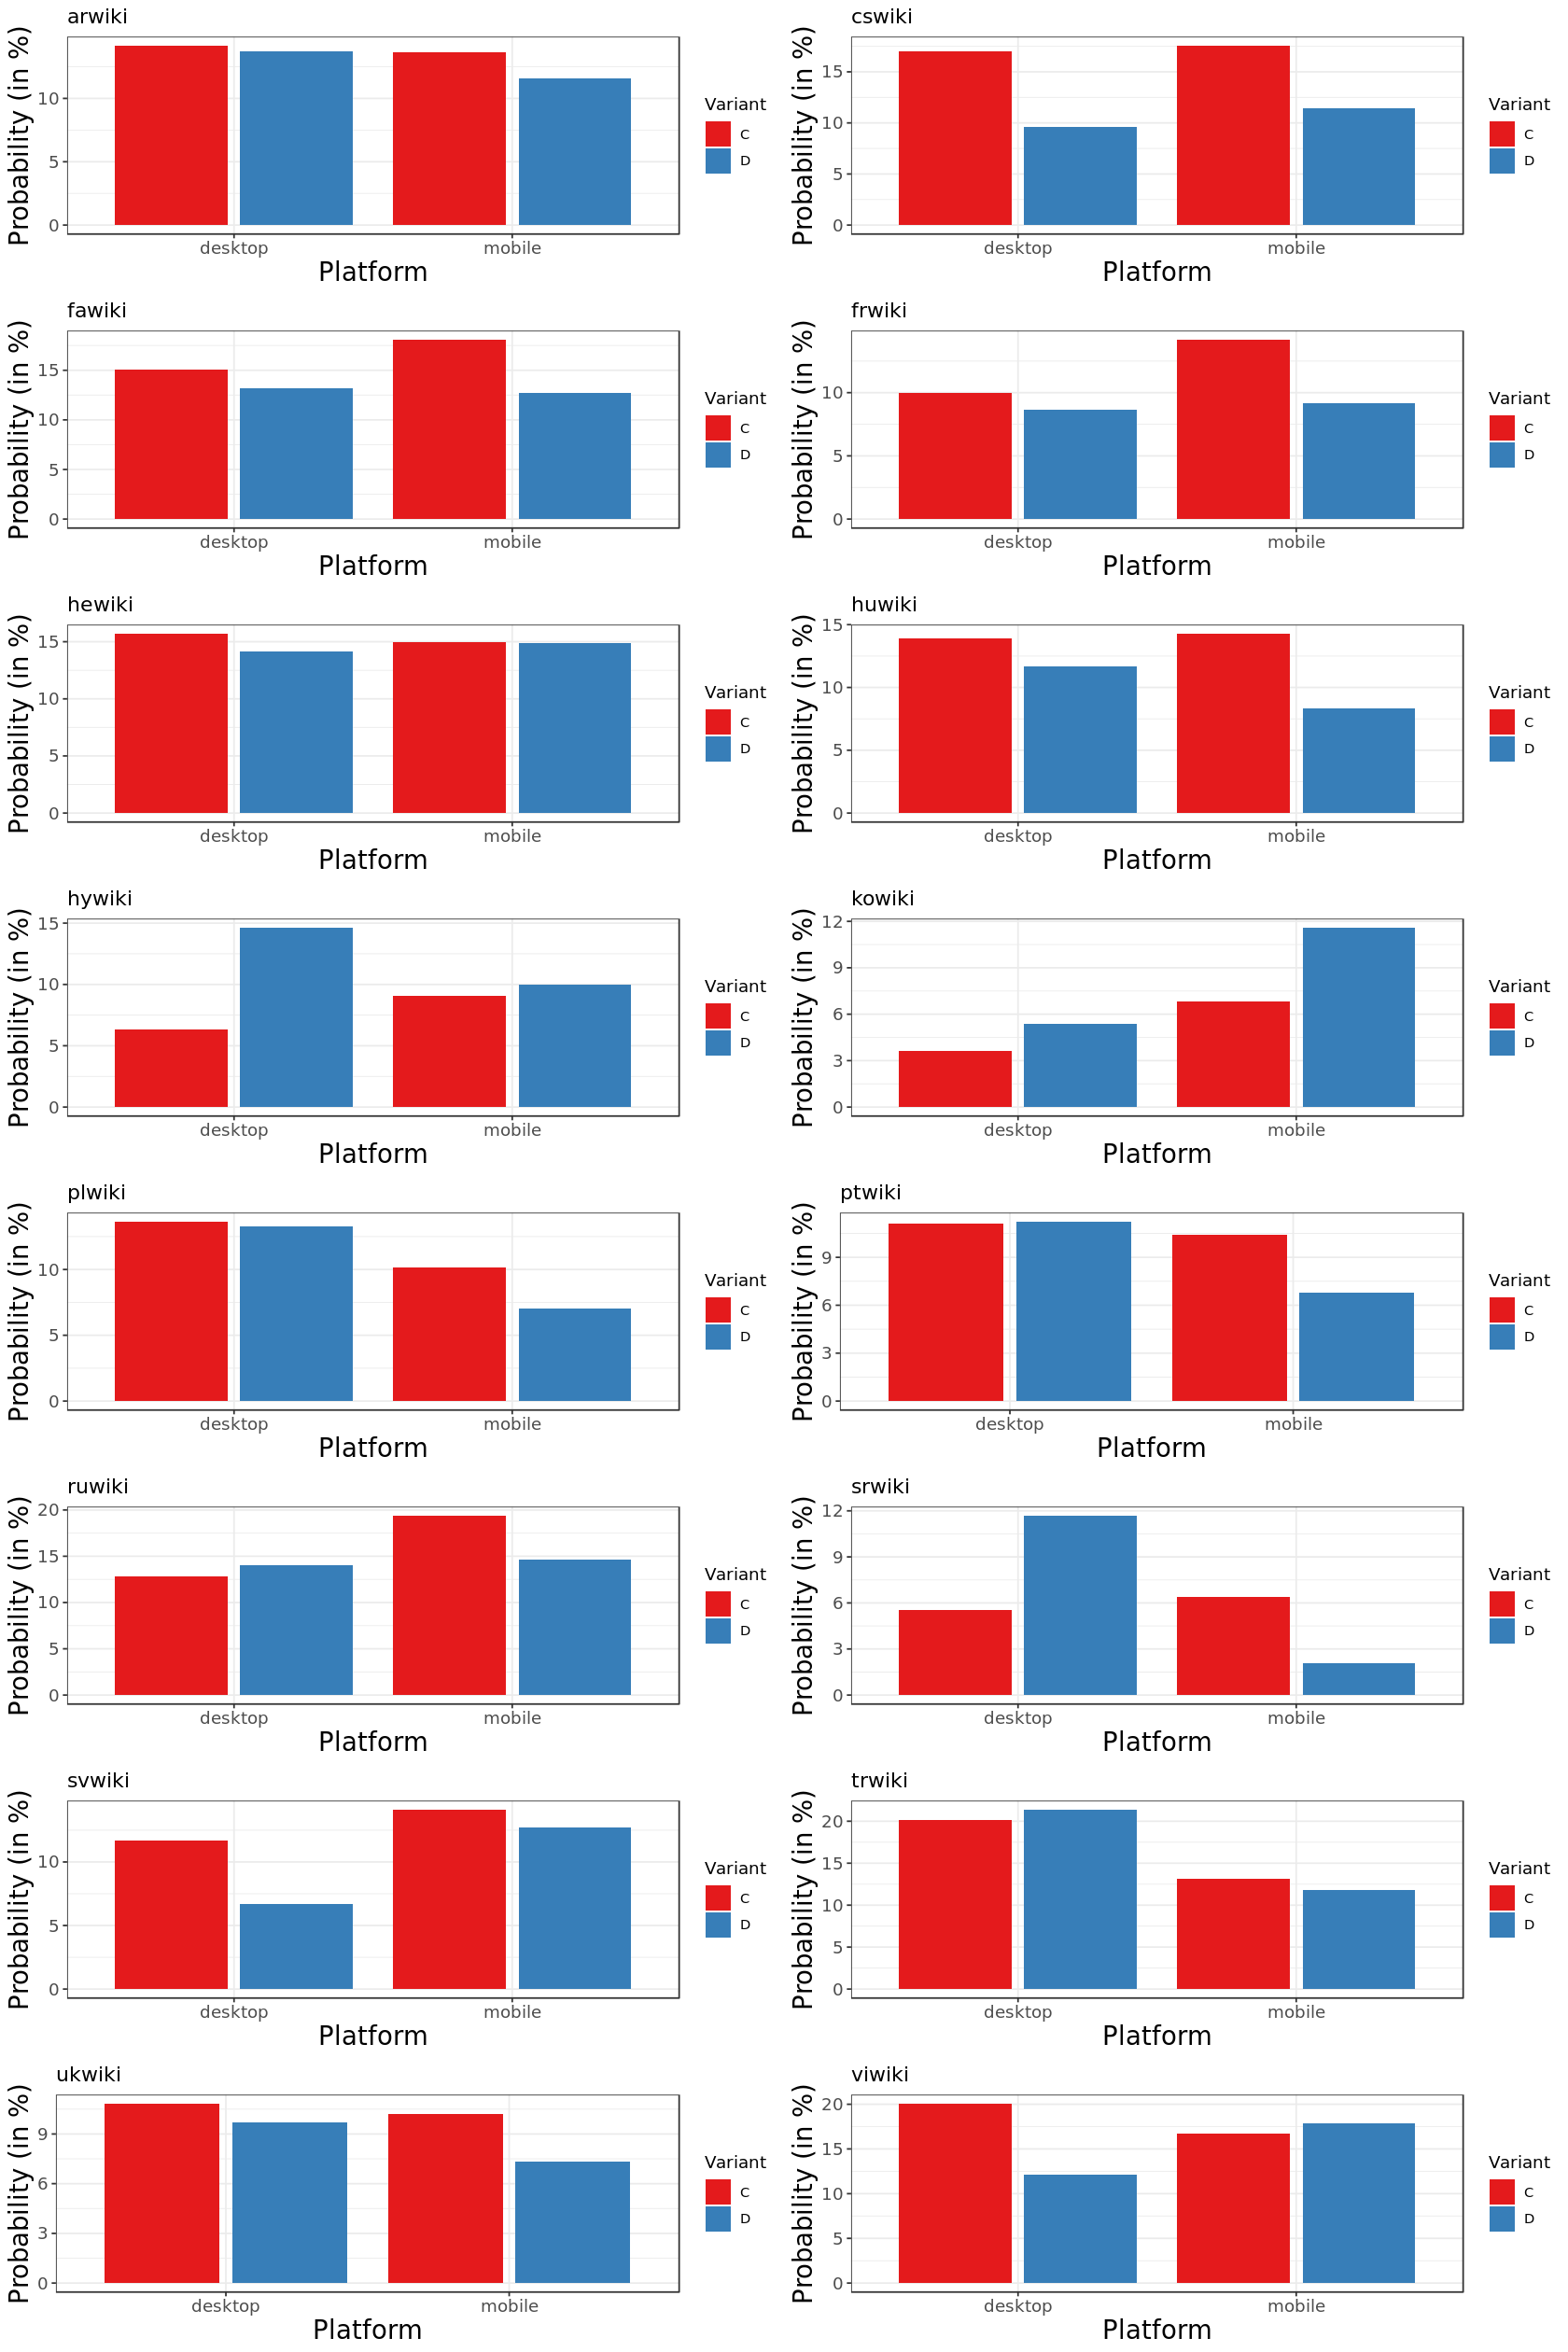

In [91]:
options(repr.plot.width = 14, repr.plot.height = 21)
grid.arrange(grobs = plots, ncol = 2)

## Summary


## Additional analysis

What's the probability difference of navigating and clicking across the dataset for C vs D?

In [120]:
merged_nav_counts[, list(n_visitors = sum(n_visitors), n_navigated = sum(n_navigated),
                      perc_navigated = 100 * sum(n_navigated) / sum(n_visitors)),
              by = c('platform', 'hp_variant')]

platform,hp_variant,n_visitors,n_navigated,perc_navigated
<fct>,<fct>,<int>,<int>,<dbl>
desktop,C,9567,2267,23.69604
desktop,D,9379,1854,19.76757
mobile,C,6798,1008,14.82789
mobile,D,6871,875,12.73468


In [116]:
merged_click_counts[, list(n_visitors = sum(n_visitors), n_clicked = sum(n_clicked),
                      perc_clicked = 100 * sum(n_clicked) / sum(n_visitors)),
              by = c('platform', 'hp_variant')]

platform,hp_variant,n_visitors,n_clicked,perc_clicked
<fct>,<fct>,<int>,<int>,<dbl>
desktop,C,9567,1223,12.78353
desktop,D,9379,1133,12.08018
mobile,C,6798,987,14.51898
mobile,D,6871,749,10.90089


In [ ]:
(1.409 - 0.820) / 1.409

In [123]:
sum(merged_click_counts$n_visitors)

[1] 32615